<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/quiz_machine_translation_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation using transformers: Overview

Transformers are a groundbreaking neural network architecture that has significantly advanced the field of natural language processing (NLP), particularly in sequence-to-sequence tasks. They've become the backbone of many modern NLP applications, including machine translation, text summarization, and language modeling.

A defining feature of transformers is their ability to process entire input sequences simultaneously. Unlike traditional recurrent models, which handle one token at a time, transformers leverage a self-attention mechanism to analyze relationships between all elements in a sequence at once. This enables the model to focus on relevant parts of the input context more efficiently and with greater flexibility.

In this tutorial, we'll explore how to build a machine translation system using the transformer architecture.



In [1]:
# import torch
# print(torch.__version__)
# print(torch.version.cuda)

In [2]:
# import numpy
# print(numpy.__version__)

In [3]:

# import torchdata
# print(torchdata.__version__)

In [4]:
# ✅ Install required packages with compatible versions for PyTorch-based English-to-French translation.
# Includes torch (with GPU support), torchtext for dataset utilities, spaCy for tokenization,
# and tqdm for progress visualization.


# Remove torchtune (if exist)
# !pip uninstall torchtune -y

# Reinstall compatible versions
!pip install torch==2.3.0 torchvision torchaudio
!pip install torchtext==0.18.0
!pip install 'portalocker>=2.0.0' --no-deps
# !pip install numpy==1.24.3


In [5]:
!pip install gputil

In [6]:
# Confirm the torch version

import torch

torch.__version__

'2.3.0+cu121'

### Loading The Data

In [7]:
import torchtext

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


##### Download the dataset

In [8]:
# !pip install -U kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishreddy18/english-to-french")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'english-to-french' dataset.
Path to dataset files: /kaggle/input/english-to-french


In [9]:
english_path = '/kaggle/input/english-to-french/small_vocab_en.csv'
french_path = '/kaggle/input/english-to-french/small_vocab_fr.csv'

with open(english_path, 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f if line.strip()]

with open(french_path, 'r', encoding='utf-8') as f:
    french_sentences = [line.strip() for line in f if line.strip()]

assert len(english_sentences) == len(french_sentences), \
    f"Mismatch: {len(english_sentences)} vs {len(french_sentences)}"

print(english_sentences[:5])
print(french_sentences[:5])

['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .', 'california is usually quiet during march , and it is usually hot in june .', 'the united states is sometimes mild during june , and it is cold in september .', 'your least liked fruit is the grape , but my least liked is the apple .']
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .', 'california est généralement calme en mars , et il est généralement chaud en juin .', 'les états-unis est parfois légère en juin , et il fait froid en septembre .', 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']


### Vocabulary Building and Sentence Encoding

This section defines helper functions and builds vocabularies for the English (source) and French (target) datasets.

1. **`yield_tokens`**: A generator function that tokenizes each sentence by lowercasing and splitting on spaces.
2. **Vocabulary Creation**:
   - Uses `build_vocab_from_iterator` to create source (`src_vocab`) and target (`trg_vocab`) vocabularies from tokenized English and French sentences.
   - Adds special tokens: `<pad>` for padding, `<sos>` (start of sentence), and `<eos>` (end of sentence).
   - Sets the default index to the padding token (`<pad>`), which is mapped to index 0.
3. **`encode_sentence`**:
   - Converts a raw sentence into a list of token indices using the corresponding vocabulary.
   - Optionally prepends `<sos>` and appends `<eos>` tokens for use in sequence models.
   - Returns the encoded sentence as a PyTorch tensor.


In [10]:
def yield_tokens(sentences):
    for sentence in sentences:
        yield sentence.strip().lower().split()

SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

src_vocab = build_vocab_from_iterator(yield_tokens(english_sentences), specials=["<pad>", "<sos>", "<eos>"])
src_vocab.set_default_index(SRC_PAD_IDX) # if a token is not found in vocab set it to 0.

trg_vocab = build_vocab_from_iterator(yield_tokens(french_sentences), specials=["<pad>", "<sos>", "<eos>"])
trg_vocab.set_default_index(TRG_PAD_IDX) # if a token is not found in vocab set it to 0.

def encode_sentence(sentence, vocab, add_specials=True):
    tokens = sentence.lower().strip().split()
    if add_specials:
        tokens = ['<sos>'] + tokens + ['<eos>']
    return torch.tensor(vocab(tokens), dtype=torch.long)

In [11]:
test_sentence = "Hello, world! It's a nice day."
tokens = list(yield_tokens([test_sentence]))  # 查看分词结果
print(tokens)

[['hello,', 'world!', "it's", 'a', 'nice', 'day.']]


### Custom Dataset and DataLoader for Machine Translation

This section defines a PyTorch-compatible dataset and a collate function to prepare batches for training a transformer-based translation model.

1. **`TranslationDataset` Class**:
   - Inherits from `torch.utils.data.Dataset`.
   - Takes lists of source (`src`) and target (`trg`) sentences along with their respective vocabularies.
   - Implements `__len__` and `__getitem__`:
     - `__getitem__` encodes each source and target sentence into tensors of token indices using `encode_sentence`.

2. **`collate_fn` Function**:
   - A custom function used to combine individual samples into a batch.
   - Uses `pad_sequence` to pad sequences in the batch so they have equal lengths.
   - Ensures correct padding values (`SRC_PAD_IDX` and `TRG_PAD_IDX`) are used for source and target batches.

3. **`DataLoader` Setup**:
   - Wraps the dataset in a `DataLoader` to enable efficient batch processing.
   - Shuffles data and uses the custom `collate_fn` to handle variable-length sequences.


In [12]:
class TranslationDataset(Dataset):
    def __init__(self, src, trg, src_vocab, trg_vocab):
        self.src = src
        self.trg = trg
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_seq = encode_sentence(self.src[idx], self.src_vocab)
        trg_seq = encode_sentence(self.trg[idx], self.trg_vocab)
        return src_seq, trg_seq

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX) # pads the seq to be the same length as the longest sequence
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch

dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, trg_vocab)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


### Spit into train, val and test set.


In [13]:
from torch.utils.data import random_split

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Total size
dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, trg_vocab)
total_size = len(dataset)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


### Positional Encoding Module

This module adds **positional information** to input embeddings, enabling the transformer model to capture the order of tokens in a sequence.

- Uses **sine and cosine functions** of different frequencies to generate position-dependent vectors.
- Applies dropout for regularization.
- The positional encodings are **precomputed and stored** as a buffer to avoid recomputation during training.

The encoding is added to the input embeddings before they are passed into the transformer layers.


### Positional Encoding Formulas

For each position `pos` and embedding dimension `i`, the positional encoding is defined as:

- **Even dimensions** (i = 0, 2, 4, ...):

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

- **Odd dimensions** (i = 1, 3, 5, ...):

$$
PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

---

### What this means:

- Each position `pos` has a **unique encoding vector**
- Each dimension `i` corresponds to a **different frequency**
- Sine and cosine allow the model to **recover relative positions**


In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pos_encoding = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term) # for all 2i
        pos_encoding[:, 1::2] = torch.cos(positions * div_term) # for all 2i + 1

        self.register_buffer('pe', pos_encoding.unsqueeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


### Sequence-to-Sequence Transformer Model

This class defines the core **Transformer-based encoder-decoder architecture** for sequence-to-sequence tasks such as machine translation.

Key components:
- **Embedding Layers**: Convert token indices from the source and target sequences into dense vector representations.
- **Positional Encoding**: Adds position information to the embeddings to help the model understand word order.
- **`nn.Transformer`**: The main transformer block containing multi-head attention, feedforward networks, and residual connections.
  - Configurable number of encoder and decoder layers.
- **Output Generator**: A linear layer that maps the transformer's output to the target vocabulary size for prediction.

The `forward` method takes:
- `src`, `tgt`: Source and target token sequences.
- `src_mask`, `tgt_mask`: Masks to prevent attention to future tokens or pad tokens.
- `src_padding_mask`, `tgt_padding_mask`: Masks to ignore padding in the attention mechanism.

It returns the output logits for the target sequence.


In [15]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, None)
        return self.generator(outs)


### Mask Generation for Transformer

Transformers require masks to control how tokens attend to one another during training, especially for tasks like language modeling and translation. This section defines two functions:

1. **`generate_square_subsequent_mask(sz)`**:
   - Creates an **upper triangular matrix** filled with `-inf` above the diagonal.
   - Prevents the decoder from attending to future tokens during training (auto-regressive behavior).

2. **`create_mask(src, tgt)`**:
   - Generates the necessary masks for both source and target sequences:
     - `src_mask`: A placeholder (all zeros) since the encoder attends to the full input.
     - `tgt_mask`: Prevents the decoder from peeking ahead using `generate_square_subsequent_mask`.
     - `src_padding_mask` and `tgt_padding_mask`: Identify padded positions in the input, so they can be ignored during attention computation.

These masks are passed to the transformer during training and inference to ensure correct attention behavior.


In [16]:
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1) # keeps the elements above main diagonal inf

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    # Ensure tgt_mask and src_mask are both bool type
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).type(torch.bool) # mask future tokens (all -infs are True)
    src_mask = torch.zeros((src_seq_len, src_seq_len), dtype=torch.bool) # all tokens of src is known (all False)

    # Padding masks for src and tgt (batch, seq_len)
    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1) # mask for pad tokens
    tgt_padding_mask = (tgt == TRG_PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


### Training

In [27]:
import torch
import torch.nn as nn
from tqdm import tqdm

# -------------------- 设置 --------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC_PAD_IDX = src_vocab['<pad>']
SRC_SOS_IDX = src_vocab['<sos>']
SRC_EOS_IDX = src_vocab['<eos>']

TRG_PAD_IDX = trg_vocab['<pad>']
TRG_SOS_IDX = trg_vocab['<sos>']
TRG_EOS_IDX = trg_vocab['<eos>']

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(trg_vocab)
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
BATCH_SIZE = 32
NUM_EPOCHS = 3

# ⚡ 初始化模型（保持 batch_first=False 默认）
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
    NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM
).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -------------------- Accuracy --------------------
def calculate_accuracy(logits, target):
    pred = logits.argmax(dim=-1)
    non_pad = target != TRG_PAD_IDX
    correct = (pred == target) & non_pad
    return correct.sum().item() / non_pad.sum().item()

# -------------------- 历史记录 --------------------
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# -------------------- 训练循环 --------------------
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (src, tgt) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} - Train")):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]  # remove <eos>
        tgt_out   = tgt[1:, :]   # remove <sos>

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        optimizer.zero_grad()
        logits = model(src, tgt_input,
                       src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                       src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(logits, tgt_out)

        # 💾 每个 batch 都保存 loss 和 accuracy
        history['train_loss'].append(loss.item())
        history['train_acc'].append(acc)

    # -------------------- 验证 --------------------
    model.eval()
    for batch_idx, (src, tgt) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} - Val")):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        with torch.no_grad():
            logits = model(src, tgt_input,
                           src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                           src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            acc = calculate_accuracy(logits, tgt_out)

            history['val_loss'].append(loss.item())
            history['val_acc'].append(acc)

# -------------------- 保存最终模型 --------------------
torch.save(model.state_dict(), "seq2seq_final.pt")
print("✅ Saved final model weights as seq2seq_final.pt")

Epoch 3 - Val: 100%|██████████| 431/431 [00:03<00:00, 110.95it/s]


✅ Saved final model weights as seq2seq_final.pt


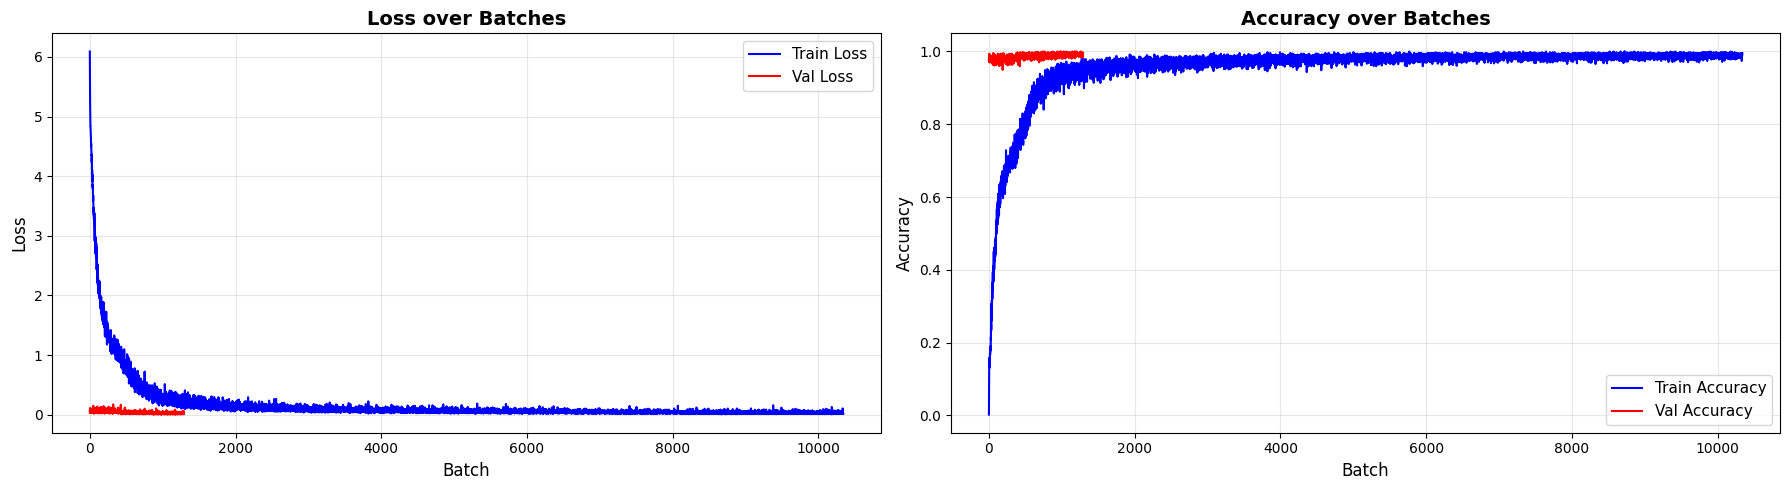

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18,5))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss')
axes[0].plot(history['val_loss'], 'r-', label='Val Loss')
axes[0].set_xlabel('Batch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss over Batches', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train Accuracy')
axes[1].plot(history['val_acc'], 'r-', label='Val Accuracy')
axes[1].set_xlabel('Batch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy over Batches', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 📊 Training Visualization

Visualize the training progress with loss, accuracy, and BLEU score curves.


### Evaluation on test set

In [29]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

itos = trg_vocab.get_itos()

# Test evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                           NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(DEVICE)
model.load_state_dict(torch.load("seq2seq_final.pt"))
model.eval()

test_loss, test_acc = 0, 0
total_bleu = 0
total_samples = 0

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Test Set"):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                       src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        test_loss += loss.item()
        test_acc += calculate_accuracy(logits, tgt_out)

        # BLEU computation
        pred_tokens = logits.argmax(-1).transpose(0, 1).tolist()
        target_tokens = tgt_out.transpose(0, 1).tolist()

        for pred, ref in zip(pred_tokens, target_tokens):
            pred_clean = [itos[tok] for tok in pred if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            ref_clean = [itos[tok] for tok in ref if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            if len(ref_clean) > 0 and len(pred_clean) > 0:
                bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie)
                total_bleu += bleu
                total_samples += 1

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)
avg_test_bleu = (total_bleu / total_samples) * 100 if total_samples > 0 else 0

print(f"\n📊 Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}, Test BLEU: {avg_test_bleu:.2f}")


Test Set: 100%|██████████| 431/431 [00:05<00:00, 85.64it/s]


📊 Test Loss: 0.0242, Test Accuracy: 0.9918, Test BLEU: 74.23


### 📊 Test Set Performance Visualization


### Checking on samples from test set

In [31]:
def translate(model, sentence):
    model.eval()
    src = encode_sentence(sentence, src_vocab).unsqueeze(1).to(DEVICE)
    num_tokens = src.shape[0]
    src_mask = torch.zeros((num_tokens, num_tokens)).type(torch.bool).to(DEVICE)

    memory = model.transformer.encoder(model.positional_encoding(model.src_tok_emb(src)), src_mask)
    ys = torch.tensor([[trg_vocab['<sos>']]], dtype=torch.long).to(DEVICE)

    for i in range(50):
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(DEVICE)
        out = model.transformer.decoder(model.positional_encoding(model.tgt_tok_emb(ys)), memory, tgt_mask)
        out = model.generator(out)
        next_word = out[-1, 0].argmax().item()
        ys = torch.cat([ys, torch.tensor([[next_word]], device=DEVICE)], dim=0)
        if next_word == trg_vocab['<eos>']:
            break

    translated = [trg_vocab.get_itos()[token] for token in ys.squeeze()][1:-1]
    return ' '.join(translated)


In [32]:
print("\n" + "="*80)
print("🔍 DETAILED TEST SET SAMPLES (10 Examples)")
print("="*80 + "\n")

num_samples = min(10, len(test_dataset))

for i in range(num_samples):
    src_sentence = test_dataset[i][0]
    tgt_sentence = test_dataset[i][1]

    # Decode token IDs back to words using vocab
    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok != SRC_PAD_IDX])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok] for tok in tgt_sentence if tok != TRG_PAD_IDX])
    predicted_text = translate(model, src_text)

    # 计算单个BLEU分数
    pred_tokens = predicted_text.split()
    ref_tokens = [tok for tok in tgt_text.split() if tok not in ['<sos>', '<eos>']]

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu_score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
    else:
        bleu_score = 0.0

    print(f"{'─' * 80}")
    print(f"Sample {i+1}:")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print(f"  📊 BLEU Score:        {bleu_score:.2f}")
    print()

print("="*80)



🔍 DETAILED TEST SET SAMPLES (10 Examples)

────────────────────────────────────────────────────────────────────────────────
Sample 1:
  📝 English:           <sos> india is sometimes hot during june , but it is never cold in autumn . <eos>
  🤖 Predicted French:  l' inde est parfois chaud en juin , mais il ne fait jamais froid à l' automne .
  ✅ Ground Truth:      <sos> l' inde est parfois chaud en juin , mais il ne fait jamais froid à l' automne . <eos>
  📊 BLEU Score:        100.00

────────────────────────────────────────────────────────────────────────────────
Sample 2:
  📝 English:           <sos> india is sometimes wet during october , but it is sometimes snowy in april . <eos>
  🤖 Predicted French:  l' inde est parfois humide en octobre , mais il est parfois enneigée en avril .
  ✅ Ground Truth:      <sos> l' inde est parfois humide en octobre , mais il est parfois enneigée en avril . <eos>
  📊 BLEU Score:        100.00

───────────────────────────────────────────────────────────

In [33]:
# 找出最好和最差的翻译（从测试集中抽样）
import random

# 设置抽样数量（可以根据需要调整）
num_analysis_samples = min(500, len(test_dataset))  # 从测试集中抽样500个样本

# 随机抽样
sample_indices = random.sample(range(len(test_dataset)), num_analysis_samples)
bleu_scores = []

print(f"🔍 从 {len(test_dataset)} 个测试样本中随机抽取 {num_analysis_samples} 个样本计算BLEU分数...")

for idx in tqdm(sample_indices, desc="Computing BLEU scores"): # Added tqdm for progress visualization
    src_sentence = test_dataset[idx][0]
    tgt_sentence = test_dataset[idx][1]

    # Decode token IDs back to words using vocab
    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    # The ground truth `tgt_text` should include <sos> and <eos> for translation but not for BLEU calculation
    # The translate function expects input without <sos> and <eos> and adds them internally.

    predicted_text = translate(model, src_text)

    # Prepare target tokens for BLEU calculation (without special tokens)
    # The `tgt_sentence` from `test_dataset` contains <sos> and <eos> as it's an encoded tensor.
    # We need to convert it to actual words and remove special tokens for comparison.
    ref_tokens_with_specials = [trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence]
    ref_tokens = [tok for tok in ref_tokens_with_specials if tok not in {trg_vocab.get_itos()[TRG_PAD_IDX], trg_vocab.get_itos()[TRG_SOS_IDX], trg_vocab.get_itos()[TRG_EOS_IDX]}]

    pred_tokens = predicted_text.split()

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
    else:
        bleu = 0.0
    bleu_scores.append((idx, bleu))

# 按BLEU分数排序
bleu_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*80)
print("🏆 TOP 5 BEST TRANSLATIONS")
print("="*80 + "\n")

for rank, (idx, bleu) in enumerate(bleu_scores[:5], 1):
    src_sentence = test_dataset[idx][0]
    tgt_sentence = test_dataset[idx][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence if tok not in {TRG_PAD_IDX}]) # Used .item() for tensor elements
    predicted_text = translate(model, src_text)

    print(f"#{rank} - BLEU Score: {bleu:.2f}")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print()

print("\n" + "="*80)
print("⚠️  TOP 5 WORST TRANSLATIONS")
print("="*80 + "\n")

for rank, (idx, bleu) in enumerate(bleu_scores[-5:][::-1], 1):
    src_sentence = test_dataset[idx][0]
    tgt_sentence = test_dataset[idx][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence if tok not in {TRG_PAD_IDX}]) # Used .item() for tensor elements
    predicted_text = translate(model, src_text)

    print(f"#{rank} - BLEU Score: {bleu:.2f}")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print()

print("="*80)
print(f"📊 抽样统计：")
print(f"   - 抽样数量: {num_analysis_samples} / {len(test_dataset)}")
print(f"   - 平均BLEU分数: {sum([score for _, score in bleu_scores]) / len(bleu_scores):.2f}")
print("="*80)

🔍 从 13786 个测试样本中随机抽取 500 个样本计算BLEU分数...


Computing BLEU scores: 100%|██████████| 500/500 [00:35<00:00, 13.99it/s]



🏆 TOP 5 BEST TRANSLATIONS

#1 - BLEU Score: 100.00
  📝 English:           <sos> china is usually chilly during september , but it is never warm in autumn . <eos>
  🤖 Predicted French:  chine est généralement froid en septembre , mais il est jamais chaud à l' automne .
  ✅ Ground Truth:      <sos> chine est généralement froid en septembre , mais il est jamais chaud à l' automne . <eos>

#2 - BLEU Score: 100.00
  📝 English:           <sos> they like apples , oranges , and mangoes . <eos>
  🤖 Predicted French:  ils aiment les pommes , les oranges et les mangues .
  ✅ Ground Truth:      <sos> ils aiment les pommes , les oranges et les mangues . <eos>

#3 - BLEU Score: 100.00
  📝 English:           <sos> california is beautiful during july , and it is sometimes pleasant in november . <eos>
  🤖 Predicted French:  californie est belle en juillet , et il est parfois agréable en novembre .
  ✅ Ground Truth:      <sos> californie est belle en juillet , et il est parfois agréable en novembre . <

### 🎯 Best and Worst Translations


🔍 Analyzing BLEU scores for 100 test samples...



Computing BLEU scores: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]
/tmp/ipython-input-3228997059.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3228997059.py:43: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


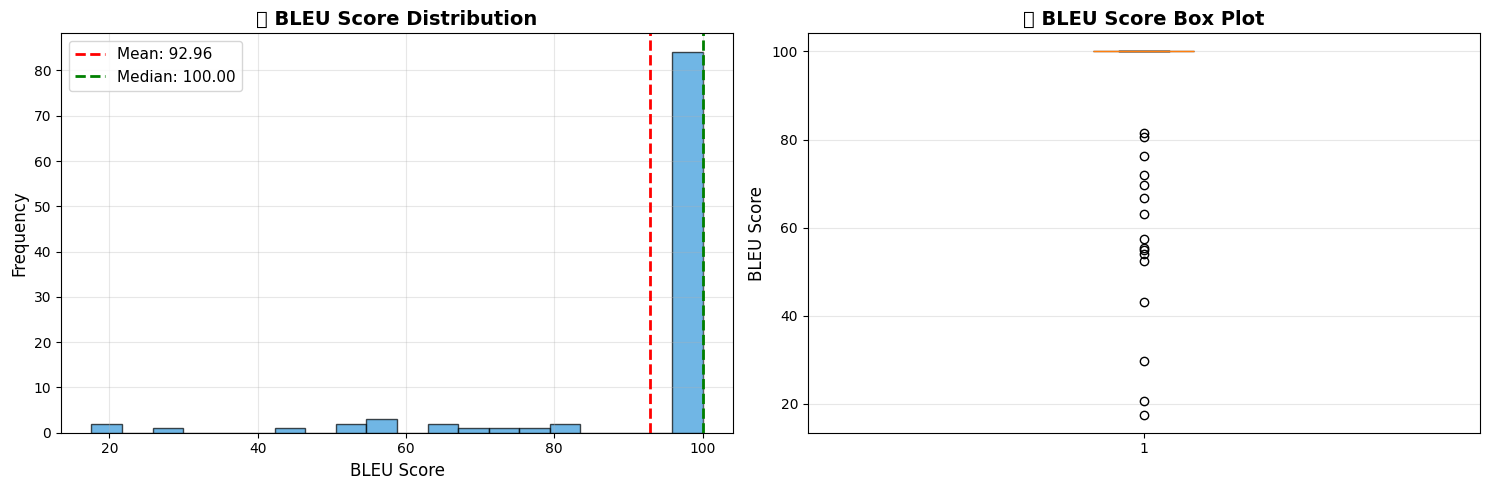


📊 BLEU SCORE STATISTICS
Mean BLEU Score:     92.96
Median BLEU Score:   100.00
Std Dev:             17.87
Min BLEU Score:      17.60
Max BLEU Score:      100.00
25th Percentile:     100.00
75th Percentile:     100.00


In [34]:
# 计算更多测试样本的BLEU分数分布
num_analysis_samples = min(100, len(test_dataset))
bleu_scores = []

print(f"🔍 Analyzing BLEU scores for {num_analysis_samples} test samples...\n")

for i in tqdm(range(num_analysis_samples), desc="Computing BLEU scores"):
    src_sentence = test_dataset[i][0]
    tgt_sentence = test_dataset[i][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok != SRC_PAD_IDX])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok] for tok in tgt_sentence if tok != TRG_PAD_IDX])
    predicted_text = translate(model, src_text)

    pred_tokens = predicted_text.split()
    ref_tokens = [tok for tok in tgt_text.split() if tok not in ['<sos>', '<eos>']]

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
        bleu_scores.append(bleu)

# 可视化BLEU分数分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 直方图
axes[0].hist(bleu_scores, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(bleu_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(bleu_scores):.2f}')
axes[0].axvline(np.median(bleu_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(bleu_scores):.2f}')
axes[0].set_xlabel('BLEU Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('📊 BLEU Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 箱线图
box = axes[1].boxplot(bleu_scores, vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('#2ecc71')
box['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('BLEU Score', fontsize=12)
axes[1].set_title('📦 BLEU Score Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 打印统计信息
print("\n" + "="*60)
print("📊 BLEU SCORE STATISTICS")
print("="*60)
print(f"Mean BLEU Score:     {np.mean(bleu_scores):.2f}")
print(f"Median BLEU Score:   {np.median(bleu_scores):.2f}")
print(f"Std Dev:             {np.std(bleu_scores):.2f}")
print(f"Min BLEU Score:      {np.min(bleu_scores):.2f}")
print(f"Max BLEU Score:      {np.max(bleu_scores):.2f}")
print(f"25th Percentile:     {np.percentile(bleu_scores, 25):.2f}")
print(f"75th Percentile:     {np.percentile(bleu_scores, 75):.2f}")
print("="*60)


### 📈 BLEU Score Distribution Analysis


In [35]:
import numpy
print(numpy.__version__)
import portalocker
print(portalocker.__version__)

2.0.2
3.2.0


####
To-Do

Q. Visualize results for other samples from the test set

Q. Try different epoch values — e.g., 4, 5, 6 — and observe how the loss changes.

Q. Experiment with different architecture configurations, such as changing the number of encoder and decoder layers.

Q. Try for different batch sizes

Q. We you find a different translation dataset try on that.

## Exercises
## Exercise 1 Study of different numbers of encoder and decoder layers

In this exercise, you will train the translation model with different numbers of encoder and decoder layers.

In the previous section, we used 3 encoder layers and 3 decoder layers. You will compare multiple layer settings and analyze their impact on parameter size and BLEU score.

E1.5.1 Re-initializing the network with different encoder/decoder layers (To do)

In [36]:
# To do
layer_settings = [
    (2, 2),
    (3, 3),
    (4, 4),
]

NUM_EPOCHS_LAYER_EXP = 2  # keep small for quick comparison
layer_experiment_results = []

E1.5.2 Training the network with new layer settings

In [ ]:
import time

def run_layer_experiment(num_encoder_layers, num_decoder_layers, num_epochs=2):
    exp_model = Seq2SeqTransformer(
        num_encoder_layers,
        num_decoder_layers,
        EMB_SIZE,
        NHEAD,
        SRC_VOCAB_SIZE,
        TGT_VOCAB_SIZE,
        FFN_HID_DIM
    ).to(DEVICE)

    exp_optimizer = torch.optim.Adam(exp_model.parameters(), lr=1e-4)
    exp_loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    t1 = time.time()
    for epoch in range(num_epochs):
        exp_model.train()
        train_loss = 0.0

        for src, tgt in train_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            tgt_input = tgt[:-1, :]
            tgt_out = tgt[1:, :]
            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

            logits = exp_model(
                src,
                tgt_input,
                src_mask.to(DEVICE),
                tgt_mask.to(DEVICE),
                src_pad_mask.to(DEVICE),
                tgt_pad_mask.to(DEVICE)
            )

            exp_optimizer.zero_grad()
            loss = exp_loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss.backward()
            exp_optimizer.step()
            train_loss += loss.item()

        print(f"Layers (enc={num_encoder_layers}, dec={num_decoder_layers}) | epoch {epoch+1}/{num_epochs} | train_loss={train_loss/len(train_loader):.4f}")

    elapsed = time.time() - t1
    return exp_model, elapsed

for enc_layers, dec_layers in layer_settings:
    trained_model, train_time = run_layer_experiment(enc_layers, dec_layers, NUM_EPOCHS_LAYER_EXP)
    layer_experiment_results.append({
        'enc_layers': enc_layers,
        'dec_layers': dec_layers,
        'model': trained_model,
        'train_time_sec': train_time
    })


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layers (enc=2, dec=2) | epoch 1/2 | train_loss=0.4198
Layers (enc=2, dec=2) | epoch 2/2 | train_loss=0.0626
Layers (enc=3, dec=3) | epoch 1/2 | train_loss=0.4229
Layers (enc=3, dec=3) | epoch 2/2 | train_loss=0.0596
Layers (enc=4, dec=4) | epoch 1/2 | train_loss=0.4509


E1.5.3 View a summary of model sizes for each layer configuration

In [ ]:
for item in layer_experiment_results:
    param_count = sum(p.numel() for p in item['model'].parameters())
    item['param_count'] = param_count
    print(
        f"enc={item['enc_layers']}, dec={item['dec_layers']} | "
        f"params={param_count:,} | train_time={item['train_time_sec']:.2f}s"
    )


E1.5.4 Evaluate BLEU score on test samples for each configuration

In [ ]:
num_eval_samples = min(200, len(test_dataset))

for item in layer_experiment_results:
    eval_model = item['model']
    eval_model.eval()
    bleu_values = []

    with torch.no_grad():
        for i in range(num_eval_samples):
            src_sentence = test_dataset[i][0]
            tgt_sentence = test_dataset[i][1]

            src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok != SRC_PAD_IDX])
            tgt_text = ' '.join([trg_vocab.get_itos()[tok] for tok in tgt_sentence if tok != TRG_PAD_IDX])

            pred_text = translate(eval_model, src_text)
            pred_tokens = pred_text.split()
            ref_tokens = [tok for tok in tgt_text.split() if tok not in ['<sos>', '<eos>']]

            if len(ref_tokens) > 0 and len(pred_tokens) > 0:
                bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
                bleu_values.append(bleu)

    avg_bleu = float(np.mean(bleu_values)) if len(bleu_values) > 0 else 0.0
    item['avg_bleu'] = avg_bleu
    print(f"enc={item['enc_layers']}, dec={item['dec_layers']} | avg BLEU={avg_bleu:.2f}")


E1.5.5 Plotting the results in one figure (To do)

Plot both average BLEU and parameter counts for each encoder-decoder layer setting.

In [ ]:
# To do
labels = [f"E{item['enc_layers']}-D{item['dec_layers']}" for item in layer_experiment_results]
bleu_scores = [item.get('avg_bleu', 0.0) for item in layer_experiment_results]
params_million = [item.get('param_count', 0) / 1_000_000 for item in layer_experiment_results]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(labels, bleu_scores, 'go--', label='avg_bleu')
ax1.set_ylabel('BLEU Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(labels, params_million, 'b^-.', label='params_million')
ax2.set_ylabel('Parameters (Million)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Encoder/Decoder Layers vs BLEU and Model Size')
plt.show()


### Resources

[The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)


### [Quiz](https://docs.google.com/forms/d/e/1FAIpQLScM0wn9cLVWCQvJemeOWlrK_RhGBmdeKOJBaqFkERFGmyqK3w/viewform?usp=dialog)